In [1]:
# https://www.kaggle.com/ajayrana/hymenoptera-data 에서 다운로드
# hymenoptera_data에는 train 과 val 폴더만 있어야 한다.
# https://tuttozurich.tistory.com/40 를 참고
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from tqdm import notebook
import time

import torchvision
from torchvision import transforms, datasets
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.io import read_image

In [3]:
# 2. 딥러닝 모델 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
     DEVICE=torch.device('cuda')
else:
     DEVICE=torch.device('cpu')

print('Using Pytorch version:',torch.__version__,'Device:',DEVICE)


Using Pytorch version: 1.11.0 Device: cuda


In [3]:
# 오류 메시지 CUDA error: device-side assert triggered 나왔을때 실행하기
# CPU로 바꾸기
DEVICE = torch.device('cpu')
print('Using Pytorch version:',torch.__version__,'Device:',DEVICE)

Using Pytorch version: 1.11.0 Device: cpu


In [5]:
BATCH_SIZE = 16
EPOCHS = 5

In [6]:
# 데이터 전처리화
# https://data-panic.tistory.com/13
# https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html
# 하위 폴더가 존재해야 함. 하위 폴더 만들어보자(0~7)

train_root = ".././Taekwondo/DataSet/train_Image"
test_root = ".././Taekwondo/DataSet/test_Image"

trains = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            ])
tests = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            ])

train_dataset = torchvision.datasets.ImageFolder(root = train_root,
                                           transform = trains)
test_dataset = torchvision.datasets.ImageFolder(root = test_root,
                                           transform = tests)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                          batch_size = BATCH_SIZE, 
                                          shuffle = True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([16]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


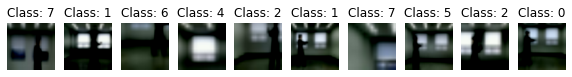

In [7]:
# 5. 데이터 확인하기
for(X_train,Y_train)in train_loader:
    print('X_train:',X_train.size(),'type:', X_train.type())
    print('Y_train:',Y_train.size(),'type:', Y_train.type())
    break

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)     # 여러 그래프 그리기, 첫숫자 : 행, 둘째 : 열
    plt.axis('off')           # 축없음
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class: ' + str(Y_train[i].item()))
# imshow : 이미지 출력

In [8]:
class CNN(nn.Module):                 # nn.Module을 상속받는 Net클래스 생성
    def __init__(self):   
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16,32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
        self.fc1=nn.Linear(8*8*16,64) # (input node수, output node수)
        self.fc2=nn.Linear(64,8)   # 이전 output node수 = 다음 input node수
        
    def forward(self,x):
        # x = self.conv1(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.conv3(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x
net = CNN()

['A01', 'A04', 'A05', 'A06', 'A07', 'A08', 'A10', 'A14']

In [15]:
#8. MLP모델 학습을 진행하며 "학습 데이터"에 대한 모델 성능을 확인하는 함수 정의(train_loader)
# https://stdworkflow.com/1223/runtimeerror-cuda-error-device-side-assert-triggered

def train(model, train_loader, optimizer, log_interval):
    model.train()         # 학습상태로 지정
    pbar = notebook.tqdm(train_loader, desc=f'Training')
    for batch_idx,(image, label) in enumerate(pbar):
        image = image.type(torch.LongTensor)
        image = image.to(DEVICE).float()        
        label = label.to(DEVICE).float()
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
#         if batch_idx % log_interval==0:
#             print("Train Epoch: {}[{}/{}({:.0f}%)]\tTrain Loss: {:.6f}"
#                   .format(Epoch,batch_idx * len(image),
#                 len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))
# 출처: https://tuttozurich.tistory.com/40 [스위스 취리히에서 칩 설계:티스토리]     

In [16]:
#9. 학습되는 과정속에서 "검증데이터"에 대한 모델 성능을 확인하는 함수 정의(test_loader)
def evaluate(model,test_loader):
    model.eval()                  # 평가상태로 지정
    test_loss=0
    correct=0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.type(torch.LongTensor)
            image = image.to(DEVICE).float()              # 8과 동일
            label = label.to(DEVICE).float()              # 8과 동일
            output = model(image)                 # 8과 동일
            test_loss += criterion(output,label).item()
            prediction = output.max(1,keepdim = True)[1]
            # MLP 모델의 output값은 크기가 10인 벡터값입니다. 
            # 계산된 벡터값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단합니다.
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            # MLP모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
                        
    test_loss /= len(test_loader.dataset)
    # 현재까지 계산된 test_loss 값을 test_loader내에 존재하는 Mini-Batch 개수(=10)만큼 나눠 평균 Loss값으로 계산.
    test_accuracy=100.*correct / len(test_loader.dataset)
    # test_loader 데이터중 얼마나 맞췄는지를 계산해 정확도를 계산합니다.
    print(f'Test Accuracy: {(test_accuracy):>0.1f}%     Loss: {test_loss:>8f} \n')

        
    return test_loss, test_accuracy


        

In [17]:
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [18]:
# optimizer, objective Function 설정하기
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(DEVICE)     # 비용 함수에 소프트맥스 함수 포함되어져 있음.



In [19]:
#10-2. MLP학습을 실행하면서 Train, Test set의 Loss및 Test set Accuracy를 확인하기
EPOCHS=5
# for Epoch in notebook.tqdm(range(EPOCHS), desc='Training...'):
for Epoch in range(EPOCHS):
    print(f'----- Epoch {Epoch+1} -----')
    train(model,train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    # print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n". format(Epoch,test_loss,test_accuracy))
    
    

----- Epoch 1 -----


Training:   0%|          | 0/244 [00:00<?, ?it/s]

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

In [33]:
# 11. Imagenet데이터로 미리 학습된 ResNet18 모델을 불러온 후 
# 개미, 벌 이미지 데이터에 맞게 Fine-tuning 해보기

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
EPOCHS = 10
for Epoch in range(1,EPOCHS + 1):
    train(model,dataloaders["train_Image"], optimizer, log_interval = 5)                
    test_loss, test_accuracy = evaluate(model, dataloaders["test_Image"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss, test_accuracy))

# Epoch 를 epoch 라 쓰면 1로 뜸 왜그런지 모르겠음 ㅋㅋ



Train Epoch: 1[0/397(0%)]	Train Loss: 0.688362
Train Epoch: 1[80/397(20%)]	Train Loss: 1.034176
Train Epoch: 1[160/397(40%)]	Train Loss: 0.818139
Train Epoch: 1[240/397(60%)]	Train Loss: 0.736470
Train Epoch: 1[320/397(80%)]	Train Loss: 0.804929

[EPOCH: 1], 	Test Loss: 0.0399, 	Test Accuracy: 63.73 %

Train Epoch: 2[0/397(0%)]	Train Loss: 0.722583
Train Epoch: 2[80/397(20%)]	Train Loss: 0.581779
Train Epoch: 2[160/397(40%)]	Train Loss: 0.663887
Train Epoch: 2[240/397(60%)]	Train Loss: 0.502173
Train Epoch: 2[320/397(80%)]	Train Loss: 0.605663

[EPOCH: 2], 	Test Loss: 0.0318, 	Test Accuracy: 78.09 %

Train Epoch: 3[0/397(0%)]	Train Loss: 0.313290
Train Epoch: 3[80/397(20%)]	Train Loss: 0.441266
Train Epoch: 3[160/397(40%)]	Train Loss: 0.460542
Train Epoch: 3[240/397(60%)]	Train Loss: 0.480929
Train Epoch: 3[320/397(80%)]	Train Loss: 0.672121

[EPOCH: 3], 	Test Loss: 0.0250, 	Test Accuracy: 85.89 %

Train Epoch: 4[0/397(0%)]	Train Loss: 0.414838
Train Epoch: 4[80/397(20%)]	Train Loss: 0